*Random Forest Training and Classification*

In [2]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn shap 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


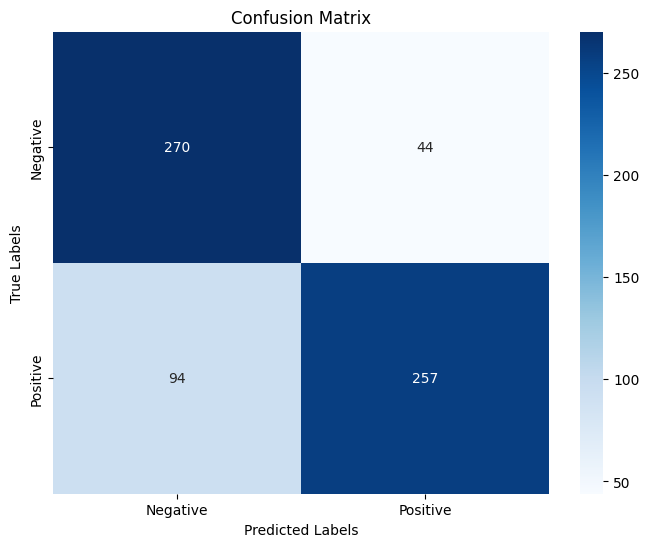

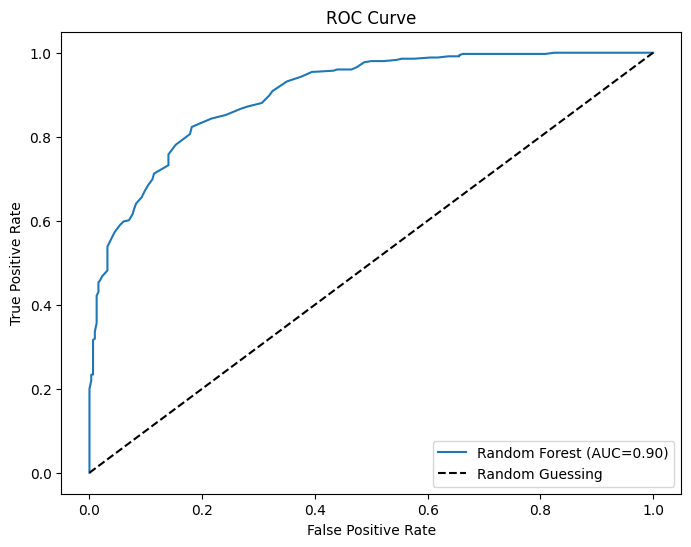

C:\Users\imohm\AppData\Local\Temp\ipykernel_4364\1275219171.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


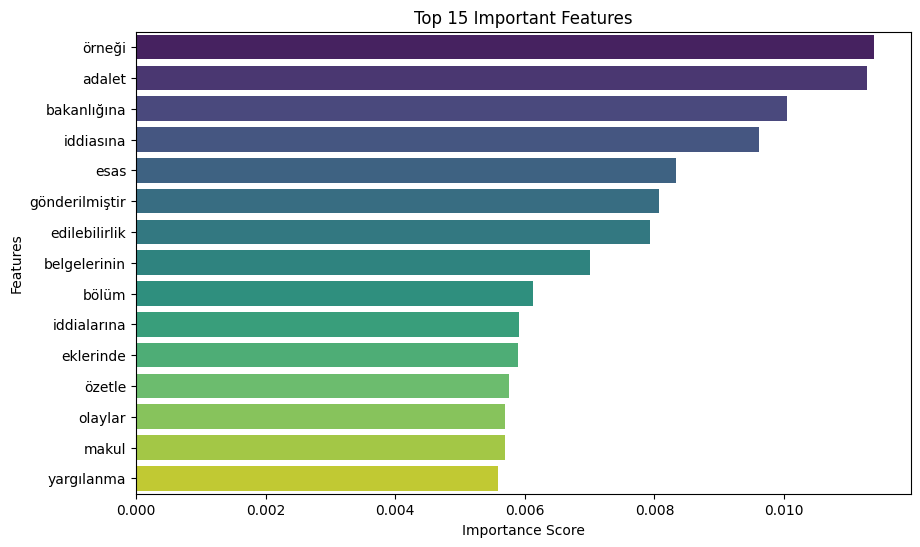


Classification Report as Table:
              precision    recall  f1-score     support
0              0.741758  0.859873  0.796460  314.000000
1              0.853821  0.732194  0.788344  351.000000
accuracy       0.792481  0.792481  0.792481    0.792481
macro avg      0.797789  0.796033  0.792402  665.000000
weighted avg   0.800907  0.792481  0.792176  665.000000


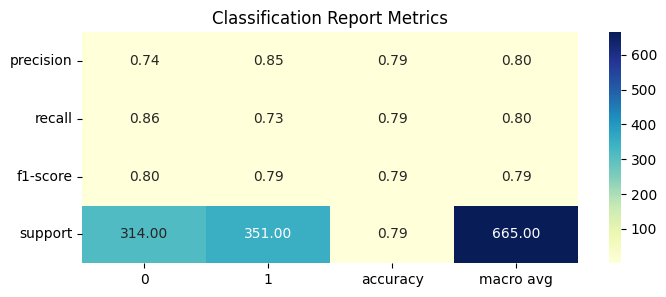

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))


train_data = load_data('train_processed.json')
dev_data = load_data('dev_processed.json')
test_data = load_data('test_processed.json')


train_dev_data = pd.concat([train_data, dev_data])
y_train = train_dev_data['labels']
y_test = test_data['labels']

# Vectorize text data using TF-IDF
max_features = 5000
vectorizer = TfidfVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(train_dev_data['text']).toarray()
X_test = vectorizer.transform(test_data['text']).toarray()

# Train Random Forest Classifier with 100 trees 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Metrics
classification_rep = classification_report(y_test, y_pred, output_dict=True)
auc_score = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance Plot
feature_importances = clf.feature_importances_
top_features_idx = feature_importances.argsort()[-15:][::-1]  
top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_idx]
top_importances = feature_importances[top_features_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title('Top 15 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


classification_df = pd.DataFrame(classification_rep).T
print("\nClassification Report as Table:")
print(classification_df)

# visualize metrices
plt.figure(figsize=(8, 3))
sns.heatmap(classification_df.iloc[:-1, :].T, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report Metrics')
plt.yticks(rotation=0)
plt.show()


*SHAP Values and Plots*